In [1]:
# Import standard libraries
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import PyTorch & Pyro libraries
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam
from pyro.infer.autoguide import AutoDiagonalNormal

# Import Sklearn libraries
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Helper function to compute regression accuracy:
# A prediction is considered correct if the relative error |y_pred - y_true|/|y_true| <= tolerance.
# If y_true is 0, that sample is skipped.
def compute_accuracy(y_true, y_pred, tolerance=0.1):
    """
    Compute regression accuracy based on relative error.
    """
    correct = 0
    total = 0
    for t, p in zip(y_true, y_pred):
        if t == 0:
            continue
        rel_error = abs(p - t) / abs(t)
        if rel_error <= tolerance:
            correct += 1
        total += 1
    return correct / total if total != 0 else 0.0

print("Library imports complete.")


Library imports complete.


In [2]:
# Step 1: Read Raw Data
# Read the data file 'data.csv' and display a preview, data structure, and descriptive statistics.

data_file = 'data.csv'
try:
    df_original = pd.read_csv(data_file)
except Exception as e:
    print("Error reading data file:", e)
    sys.exit(1)

print("Raw Data Preview:")
display(df_original.head())

print("\nData Structure:")
df_original.info()

print("\nDescriptive Statistics:")
display(df_original.describe(include='all'))


Raw Data Preview:


,Date,County,Temperature,Rainfall,Humidity,Male_Admissions,Female_Admissions,Population,Water_Bodies
0,2013-01-31,C1,25.618102,NaN,73.919637,30.0,40.0,500,5
1,2013-02-28,C1,20.308767,290.972956,79.946558,NaN,NaN,500,5
2,2013-03-31,C1,27.871620,119.958292,32.799940,40.3,NaN,500,5
3,2013-04-30,C1,29.113173,51.157237,NaN,106.0,75.0,500,5
4,2013-05-31,C1,30.248953,182.998997,79.991695,48.0,36.0,500,5



Data Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               240 non-null    object 
 1   County             240 non-null    object 
 2   Temperature        224 non-null    float64
 3   Rainfall           210 non-null    float64
 4   Humidity           205 non-null    float64
 5   Male_Admissions    228 non-null    float64
 6   Female_Admissions  226 non-null    float64
 7   Population         240 non-null    int64  
 8   Water_Bodies       240 non-null    int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 17.0+ KB

Descriptive Statistics:


,Date,County,Temperature,Rainfall,Humidity,Male_Admissions,Female_Admissions,Population,Water_Bodies
count,240,240,224.000000,210.000000,205.000000,228.000000,226.000000,240.000000,240.000000
unique,120,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2013-01-31,C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,27.487052,144.472039,58.785977,61.424561,64.494690,600.000000,6.500000
std,NaN,NaN,4.142633,88.724900,17.088528,24.826869,26.208127,100.208987,1.503135
min,NaN,NaN,20.015442,0.775204,30.541824,21.000000,25.000000,500.000000,5.000000
25%,NaN,NaN,24.189768,68.276918,43.532409,40.000000,44.000000,500.000000,5.000000
50%,NaN,NaN,27.874535,137.925002,58.389972,56.200000,60.000000,600.000000,6.500000
75%,NaN,NaN,30.968102,223.984256,73.919637,81.250000,82.750000,700.000000,8.000000


In [3]:
# Step 2: Initial Data Preprocessing & Rounding
# Convert the 'Date' column to datetime format and extract the 'Month'.
# Round the Temperature, Rainfall, and Humidity columns to two decimal places.

df_cleaned = df_original.copy()
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])
df_cleaned['Month'] = df_cleaned['Date'].dt.month

for col in ['Temperature', 'Rainfall', 'Humidity']:
    df_cleaned[col] = df_cleaned[col].round(2)

print("Preview of processed data (Date, Month, Temperature, Rainfall, Humidity):")
display(df_cleaned[['Date', 'Month', 'Temperature', 'Rainfall', 'Humidity']].head())


Preview of processed data (Date, Month, Temperature, Rainfall, Humidity):


,Date,Month,Temperature,Rainfall,Humidity
0,2013-01-31,1,25.62,NaN,73.92
1,2013-02-28,2,20.31,290.97,79.95
2,2013-03-31,3,27.87,119.96,32.80
3,2013-04-30,4,29.11,51.16,NaN
4,2013-05-31,5,30.25,183.00,79.99


In [4]:
# Step 3: Fill Missing Values and Round Up Admissions
# Fill missing values in each column using the monthly average.
# For Male_Admissions and Female_Admissions, apply ceiling (round up) regardless of missing values.
# Then compute Total_Admissions as the sum of Male_Admissions and Female_Admissions.

def fill_missing_by_month(df, col, round_up=False):
    """
    Fill missing values in column `col` using the monthly average.
    If round_up is True, apply ceiling (round up) to the value.
    """
    monthly_avg = df.groupby('Month')[col].mean()
    
    def fill_func(row):
        if pd.isna(row[col]):
            val = monthly_avg.loc[row['Month']]
        else:
            val = row[col]
        return int(np.ceil(val)) if round_up else val
    
    df[col] = df.apply(fill_func, axis=1)
    return df

# Fill missing values for Temperature, Rainfall, and Humidity (retain two decimals)
for col in ['Temperature', 'Rainfall', 'Humidity']:
    df_cleaned = fill_missing_by_month(df_cleaned, col, round_up=False)
    df_cleaned[col] = df_cleaned[col].round(2)

# Fill missing values for Male_Admissions and Female_Admissions (round up)
for col in ['Male_Admissions', 'Female_Admissions']:
    df_cleaned = fill_missing_by_month(df_cleaned, col, round_up=True)

# Compute Total_Admissions
df_cleaned['Total_Admissions'] = df_cleaned['Male_Admissions'] + df_cleaned['Female_Admissions']

print("Missing values after filling:")
print(df_cleaned[['Temperature', 'Rainfall', 'Humidity', 'Male_Admissions', 'Female_Admissions']].isna().sum())

display(df_cleaned[['Date', 'Month', 'Temperature', 'Rainfall', 'Humidity', 
                     'Male_Admissions', 'Female_Admissions']].head(10))


Missing values after filling:
Temperature          0
Rainfall             0
Humidity             0
Male_Admissions      0
Female_Admissions    0
dtype: int64


,Date,Month,Temperature,Rainfall,Humidity,Male_Admissions,Female_Admissions
0,2013-01-31,1,25.62,140.72,73.92,30,40
1,2013-02-28,2,20.31,290.97,79.95,58,63
2,2013-03-31,3,27.87,119.96,32.80,41,72
3,2013-04-30,4,29.11,51.16,55.94,106,75
4,2013-05-31,5,30.25,183.00,79.99,48,36
5,2013-06-30,6,22.77,290.88,76.51,34,29
6,2013-07-31,7,31.21,161.91,63.82,102,124
7,2013-08-31,8,24.40,144.95,41.93,100,85
8,2013-09-30,9,29.35,99.27,33.81,51,60
9,2013-10-31,10,30.70,228.24,55.13,95,68


In [5]:
# Step 4: Save Cleaned Data
# Save the cleaned data to a file named 'cleaned_data.csv'.

df_cleaned.to_csv('cleaned_data.csv', index=False)
print("Cleaned data saved to cleaned_data.csv")


Cleaned data saved to cleaned_data.csv


In [6]:
# Step 5: Feature Engineering
# Read the cleaned data, extract Month and Quarter from the Date,
# perform one-hot encoding for County (if available), and convert Date to an ordinal number.
# Then, define the feature columns.

df = pd.read_csv('cleaned_data.csv')
df['Date'] = pd.to_datetime(df['Date'])

df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter

if 'County' in df.columns:
    df = pd.get_dummies(df, columns=['County'], drop_first=True)

df['Date_Ordinal'] = df['Date'].map(pd.Timestamp.toordinal)

feature_cols = ['Temperature', 'Rainfall', 'Humidity', 'Population',
                'Water_Bodies', 'Month', 'Quarter', 'Date_Ordinal']
if 'County_C2' in df.columns:
    feature_cols.append('County_C2')

X = df[feature_cols].values
y = df['Total_Admissions'].values

print("Feature columns used for modeling:", feature_cols)
display(df[feature_cols].head(10))


Feature columns used for modeling: ['Temperature', 'Rainfall', 'Humidity', 'Population', 'Water_Bodies', 'Month', 'Quarter', 'Date_Ordinal', 'County_C2']


,Temperature,Rainfall,Humidity,Population,Water_Bodies,Month,Quarter,Date_Ordinal,County_C2
0,25.62,140.72,73.92,500,5,1,1,734899,False
1,20.31,290.97,79.95,500,5,2,1,734927,False
2,27.87,119.96,32.80,500,5,3,1,734958,False
3,29.11,51.16,55.94,500,5,4,2,734988,False
4,30.25,183.00,79.99,500,5,5,2,735019,False
5,22.77,290.88,76.51,500,5,6,2,735049,False
6,31.21,161.91,63.82,500,5,7,3,735080,False
7,24.40,144.95,41.93,500,5,8,3,735111,False
8,29.35,99.27,33.81,500,5,9,3,735141,False
9,30.70,228.24,55.13,500,5,10,4,735172,False


In [7]:
# Step 6: Time Series Split
# Split the data into training and test sets based on time.
# The first 80% of the dates are used for training and the remaining 20% for testing.

unique_dates = df['Date'].drop_duplicates().sort_values()
cutoff_index = int(len(unique_dates) * 0.8)
cutoff_date = unique_dates.iloc[cutoff_index]

train_idx = df['Date'] <= cutoff_date
test_idx = df['Date'] > cutoff_date

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

print("Number of training samples:", X_train.shape[0])
print("Number of test samples:", X_test.shape[0])
print("Cutoff date:", cutoff_date)


Number of training samples: 194
Number of test samples: 46
Cutoff date: 2021-01-31 00:00:00


In [8]:
# Step 7: Data Normalization
# Normalize the feature matrices using StandardScaler and convert them to PyTorch tensors.

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float)
y_train_torch = torch.tensor(y_train, dtype=torch.float)
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float)
y_test_torch = torch.tensor(y_test, dtype=torch.float)

print("Data normalization complete and converted to PyTorch tensors.")


Data normalization complete and converted to PyTorch tensors.


In [20]:
# Step 8: Define a Deeper Bayesian Neural Network with Learnable Noise
# Build a BNN with two hidden layers (each with 50 neurons) and a learnable noise parameter (log_sigma).

class BayesianNN(PyroModule):
    def __init__(self, n_features, hidden_size1=50, hidden_size2=50):
        super().__init__()
        # First layer
        self.linear1 = PyroModule[nn.Linear](n_features, hidden_size1)
        self.linear1.weight = PyroSample(
            dist.Normal(0., 1.).expand([hidden_size1, n_features]).to_event(2)
        )
        self.linear1.bias = PyroSample(
            dist.Normal(0., 1.).expand([hidden_size1]).to_event(1)
        )

        # Second layer
        self.linear2 = PyroModule[nn.Linear](hidden_size1, hidden_size2)
        self.linear2.weight = PyroSample(
            dist.Normal(0., 1.).expand([hidden_size2, hidden_size1]).to_event(2)
        )
        self.linear2.bias = PyroSample(
            dist.Normal(0., 1.).expand([hidden_size2]).to_event(1)
        )

        # Output layer
        self.linear3 = PyroModule[nn.Linear](hidden_size2, 1)
        self.linear3.weight = PyroSample(
            dist.Normal(0., 1.).expand([1, hidden_size2]).to_event(2)
        )
        self.linear3.bias = PyroSample(
            dist.Normal(0., 1.).expand([1]).to_event(1)
        )

        # Learnable observation noise (log_sigma)
        self.log_sigma = PyroSample(dist.Normal(torch.tensor(0.), torch.tensor(0.1)))

    def forward(self, x, y=None):
        # Forward pass
        h1 = torch.relu(self.linear1(x))
        h2 = torch.relu(self.linear2(h1))
        mean = self.linear3(h2).squeeze(-1)  # [batch_size]

        # Compute learnable noise sigma = exp(log_sigma)
        sigma = torch.exp(self.log_sigma)

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

bnn = BayesianNN(n_features=X_train_torch.shape[1], hidden_size1=50, hidden_size2=50)
print("Bayesian Neural Network defined.")


Bayesian Neural Network defined.


In [21]:
# Step 9: Train the BNN (SVI)
# Train the Bayesian Neural Network using SVI. 
# This version runs for 20,000 iterations and prints the loss every 300 iterations.

# Variational bootstrapping using automatic derivatives
guide = AutoDiagonalNormal(bnn)

# Defining the optimizer and loss
optim = Adam({"lr": 0.005})
svi = SVI(bnn, guide, optim, loss=Trace_ELBO())

pyro.clear_param_store()
n_steps = 15000
for step in range(n_steps):
    loss = svi.step(X_train_torch, y_train_torch)
    if step % 300 == 0:
        print(f"[Iteration {step}] loss={loss:.4f}")

print("Training completed.")


[Iteration 0] loss=1309380.2189
[Iteration 300] loss=85171.7396
[Iteration 600] loss=40960.0680
[Iteration 900] loss=29297.8715
[Iteration 1200] loss=20713.9639
[Iteration 1500] loss=13513.5313
[Iteration 1800] loss=11494.0654
[Iteration 2100] loss=9332.7531
[Iteration 2400] loss=7652.5120
[Iteration 2700] loss=8189.4936
[Iteration 3000] loss=6731.6032
[Iteration 3300] loss=6495.8978
[Iteration 3600] loss=6836.8195
[Iteration 3900] loss=5626.7829
[Iteration 4200] loss=6384.2835
[Iteration 4500] loss=5731.5118
[Iteration 4800] loss=4918.8407
[Iteration 5100] loss=4990.2198
[Iteration 5400] loss=4688.0223
[Iteration 5700] loss=4296.5789
[Iteration 6000] loss=4089.4547
[Iteration 6300] loss=3868.2238
[Iteration 6600] loss=3896.7747
[Iteration 6900] loss=3610.6565
[Iteration 7200] loss=3481.8344
[Iteration 7500] loss=3207.0297
[Iteration 7800] loss=3049.3101
[Iteration 8100] loss=3503.6320
[Iteration 8400] loss=2952.8209
[Iteration 8700] loss=2731.7372
[Iteration 9000] loss=2662.4562
[Iter

In [22]:
# Step 10: Prediction (Using Predictive API)
# Use Pyro's Predictive API to sample from the posterior on the test set.
# Compute the predicted mean, standard deviation, RMSE, 95% prediction interval coverage, and prediction accuracy.

n_samples = 200
predictive = Predictive(
    model=bnn,
    guide=guide,
    num_samples=n_samples,
    return_sites=["_RETURN"]
)

with torch.no_grad():
    samples = predictive(X_test_torch)
    preds = samples["_RETURN"].detach().cpu().numpy()  # shape: [n_samples, n_test]

y_pred_mean = preds.mean(axis=0)
y_pred_std = preds.std(axis=0)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_mean))
lower_bound = y_pred_mean - 1.96 * y_pred_std
upper_bound = y_pred_mean + 1.96 * y_pred_std
coverage = np.mean((y_test >= lower_bound) & (y_test <= upper_bound))

print(f"\nBNN (Deeper+LearnableNoise) Test RMSE: {rmse:.2f}")
print(f"95% Prediction Interval Coverage: {coverage*100:.2f}%")



BNN (Deeper+LearnableNoise) Test RMSE: 47.11
95% Prediction Interval Coverage: 89.13%


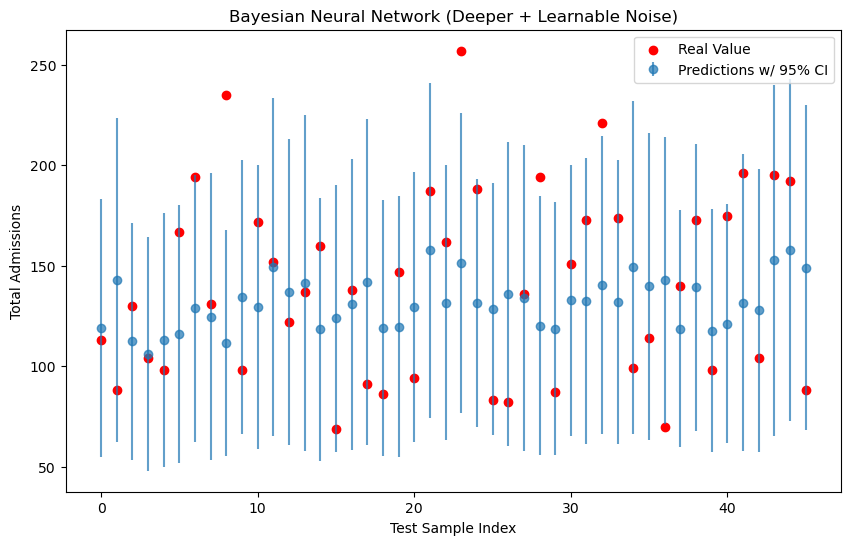

In [23]:
# Step 11: Visualization
# Plot the predicted mean with 95% confidence intervals and compare with the real values.

plt.figure(figsize=(10,6))
plt.errorbar(
    range(len(y_test)),
    y_pred_mean,
    yerr=1.96*y_pred_std,
    fmt='o',
    label='Predictions w/ 95% CI',
    alpha=0.7
)
plt.scatter(range(len(y_test)), y_test, color='red', label='Real Value')
plt.xlabel("Test Sample Index")
plt.ylabel("Total Admissions")
plt.title("Bayesian Neural Network (Deeper + Learnable Noise)")
plt.legend()
plt.show()


In [30]:
## End of Notebook
## This notebook presented the complete process for predicting hospital admissions using a Bayesian Neural Network. 
## All steps—from data preprocessing and feature engineering to training, prediction, and visualization—have been executed sequentially.
